# Spin simulator tutorial

This tutorial will teach you how to simulate spin dynamics of the system of QDs with __spin_simulator__ module. You will learn how to compute the dynamics of internal system parameters and track additional parameters such as fidelity, purity, evolution of subsystems etc. 

The tutorial is regularly updated with various examples such as Rabi oscillations, individual electron manipulation with *g*-factor variation, exchange-driven effects, quantum gates and algorithms.

The theoretical foundations of the simulator could be found in the write-up file: https://www.overleaf.com/3252553442tbqcmxntqvtk. 

## 1. Add the current location to path


In order for this tutorial to work, you will need to run this from the "tutorials" folder.

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

## 2. Import the relevant modules

In [2]:
#Spin simulator module
import qudipy.spinsimulator.spin_simulator as sps

#Pulse generating module
import qudipy.spinsimulator.pulse_generators as pulsegens

#Circuit module containing control pulses and ideal circuits
import qudipy.circuit as circ

#Constants class
from qudipy.utils.constants import Constants

#For data manipulation
import numpy as np
import qudipy.qutils.matrices as matr
import qudipy.qutils.math as qmath
import math

#For plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


## 3. Define the system and pulse parameters

### System: SpinSys object

The system of the electrons in the quantum dots is described by the complex density matrix $\rho$ whose evolution is of interest. We create several density matrices relevant for the examples given below. The number of electrons in the system is inferred from the size of $\rho$; if it changes over time (e.g. due to measurements), the parameter $N_0$ should be specified to indicate the maximal possible electron number. 

In [3]:
#creating an instance of Constants class, assuming that the material is GaAs
consts = Constants("GaAs")

rho_up = np.array([[1,0],[0,0]])    
    # one electron in pure spin-up state
    
rho_up_down = np.kron(np.array([[1,0],[0,0]]) , np.array([[0,0],[0,1]]))    
    # two-electron pure |↑↓> state


You could provide additional constant parameters such as temperature $T$, Zeeman field $\vec{B_0}= B_0 \hat{z}$, electron spin resonance (ESR) frequency $f_{RF} = \frac{\omega_{RF}}{2\pi}$, spin relaxation time $T_1$ and dephasing time $T_2$ to define the system. 

__Note: all units are SI hereinafter, unless otherwise specified__

In [4]:
#system parameters needed for a resonant Rabi pulse;
#see the next section for the physical explanation

B0 = 1    
g = 2 
larmor_freq = g *consts.muB *B0 / consts.h

params_rabi = {"B_0" : B0, "T_2" : 5e-7, "T" : 4, "f_rf"  : larmor_freq }    

The central object of the spin simulator is `SpinSys` class. Its instance is used to define the current state of the investigated spin system. It also contains methods responsible for evolving the system spin state and tracking system parameters during the evolution (this will be discussed in the next section). Using the system density matrix and constant parameters, we need to create a SpinSys object to move forward:



In [5]:
rabi_system = sps.SpinSys(rho_up, time=0, **params_rabi)

The default values for the optional parameters are as follows: $T_1=T_2 =\infty$ (no decoherence), $B_0=0, T=0$. If unspecified, the ESR frequency is equated to Larmor frequency: $f_{RF}= \dfrac{g \mu B_0}{h}.$ The `time` parameter incorporates the point in time at which the system is defined; it is optional, too (default value 0).


### Control pulses with ControlPulse objects

The control pulse should be defined as an instance of `ControlPulse` class from `qudipy.circuit` module.

In [6]:
rabi_test_pulse = circ.ControlPulse("Rabi test pulse", "effective", pulse_length=1e-6) 
    #pulse for constant Rabi oscillations

The physical quantities that could change during the pulse iclude:  
- RF magnetic field magnitude `"B_rf"` and phase `"phi"` (in rotation frame)
- Deviation g-factor of the $i^{th}$ electron `"delta_g_{i}"`
- Exchange couplings between the $i^{th}$ and $(i+1)^{st}$ electrons `"J_{i}"`

They are to be specified as attributes of the `ControlPulse` object by means of its `add_control_variable` method (the unspecified parameters are automaticaclly assigned zero values during the simulation). The sequences of the parameter values should be passed as 1D arrays of equal size; time step is assumed to be constant and is inferred automatically based on the pulse length. 

In [7]:
lisbrf =  [1e-3] * 3000 #  List of B_rf values
rabi_test_pulse.add_control_variable(var_name="B_rf", 
                                     var_pulse=np.array(lisbrf)) # constant Rabi pulse

## 3. System evolution 

The method `evolve` of a `SpinSys` object simulates the system evolution under a given pulse or iterable (tuple or list) of pulses. The iterable could be irregular, like, for example, `[pulse1, pulse2, [pulse3, (pulse4, pulse5)], pulse6]`. It returns a dictionary of 1D arrays of the user-specified parameters that are monitored throughout the simulation:
- Purity of the density matrix 
    - Evaluated when `is_purity=True` is specified
    - `"purity"` entry in the resultant dictionary  
- Fidelity of the density matrix with respect to the theoretical (initial,expected final, etc.) matrix
    - Evaluated when `is_fidelity=True` and the reference matrix `rho_reference` are specified
    - `"fidelity"` entry in the resultant dictionary  
- 1-electron density submatrices 
    - Evaluated when a qubit / iterable of qubits to track `track_qubits` is specified
    - `"submatrix_{i}"` entry in the resultant dictionary  
-  Bloch vector components $\langle \sigma_{x} \rangle, \langle \sigma_{y} \rangle, \langle \sigma_{z} \rangle$
    - Evaluated when `are_Bloch_vectors=True` and an iterable of qubits to track `track_qubits` are specified
    - `"sigma_x_{i}"`,`"sigma_y_{i}"`, `"sigma_z_{i}"` entries in the resultant dictionary  
    
The other entry in the final dictionary, `"time"`, incorporates all points in time during the simulation.

An optional parameter `track_points_per_pulse` could be used to record only a part of the parameter values during the pulse to save memory (default is 100). In particular, it could be equated to 2 if one wants to record only the parameters before and after each pulse.


## 4. Basic examples

### Rabi oscillations

As a simplest example, we consider constant Rabi oscillations with $\phi =0$, and assume Lande factor to be $g=2$. 

The Hamiltonian reads as follows: $H = \frac{\hbar(\omega - \omega_{RF})}{2} \sigma_z + \frac{\hbar\Omega}{2} \sigma_x$, where $\omega = \frac{2\mu_B B_0}{\hbar}$ is Larmor frequency, $ \Omega = \frac{2\mu_B B_{rf}}{\hbar}$ is Rabi frequency.

At resonance ($\omega = \omega_{RF}$), the electron spin state oscillates between $|\uparrow \rangle$ and $|\downarrow \rangle$ with the frequency $\Omega$. Let us simulate it. 

_Note: since this example contains objects defined earlier, re-evaluate all the notebook to run it correctly._

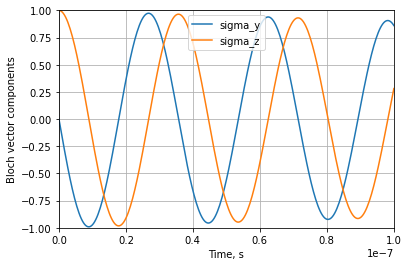

In [8]:

rabi_oscillations = rabi_system.evolve(rabi_test_pulse, 
                               is_purity=True, 
                               is_fidelity=True,
                               rho_reference=rabi_system.rho,   
                                       #initial matrix used as a reference
                               track_qubits=1, 
                               are_Bloch_vectors=True,
                                track_points_per_pulse=2500
)

#showing oscillating Bloch vector components

plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["sigma_y_1"]), label="sigma_y" ) 
plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["sigma_z_1"]), label="sigma_z" )

plt.grid()
plt.rc('grid', linestyle="dotted", color='gray') #adding grid

plt.xlabel("Time, s")
plt.ylabel("Bloch vector components")

plt.legend(loc="upper center")
plt.axis([0,1e-7,-1,1])
plt.show()


Clearly, the sine waves are shifted by $\frac{\pi}{2}$ in phase, as expected. Also, the theoretical oscillation period $T_{th}=\pi\hbar/\mu_B B_{x}= 35.7 \mathrm{ ns}$  is in good agreement with the simulated result.  

The plots of purity and fidelity with respect to the initial state reveal the dephasing process with time constant $T_2$: 

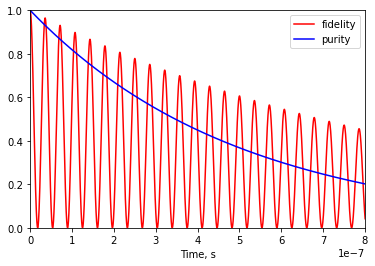

In [9]:
#showing dephasing

plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["fidelity"]),'r', label="fidelity") 
plt.plot(rabi_oscillations["time"], 
         np.real(rabi_oscillations["purity"]), 'b', label="purity" )

plt.xlabel("Time, s")
plt.legend(loc="upper right")
plt.axis([0,8e-7,0,1])

plt.show()


The system purity hits the value $1/e$ at around 500 ns, which is consistent with the definition of $T_2=5\cdot10^{-7}$ . Check if this equality holds for different system parameters.

### Addressing individual qubits with the deviation $g-$factors

If we could address electron g-factors individually, we could tune them on and off resonance. Indeed, the Hamiltonian in this case is as follows (phase is still zero):

$$H = \sum_i \frac{\hbar}{2}\left(\omega\left(1+\frac{\delta g_i}{2}\right) - \omega_{RF} \right) \sigma_{z,i} + \frac{\hbar\Omega}{2} \sigma_{x,i}$$

Consider a two-electron system in the $|\uparrow \downarrow\rangle$ configuration. In this case, we need to specify `delta_g_{i}` control variables. We specify meander-like sequences for them:

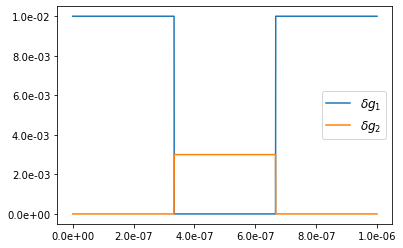

In [10]:
#creating spin system, starting with the same parameters as before
g_manip_system = sps.SpinSys(rho_up_down, **params_rabi) 
#reducing dissipation
g_manip_system.T_2 = 1e-5

lisdg1 = [1e-2] * 1000 + [0] * 1000 + [1e-2] * 1000   #delta_g_1 pulse
lisdg2 = [0] * 1000 + [3e-3] * 1000 + [0] * 1000      #delta_g_2 pulse

#plotting pulses 
listime = np.linspace(0, 1e-6, num=3000)

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
     # for scientific  number format

ax.plot(listime, lisdg1, label = '$\delta g_1$')
ax.plot(listime, lisdg2, label = '$\delta g_2$')
ax.legend(loc='center right', fontsize='large')


The other variables are chosen so that no deviation in $g-$factor corresponds to the resonance

In [11]:
#starting with the same pulse as before
g_manip_pulse = rabi_test_pulse

# adding g factor control variables 
g_manip_pulse.add_control_variable("delta_g_1", np.array(lisdg1))
g_manip_pulse.add_control_variable("delta_g_2", np.array(lisdg2))

# performing the system evolution
g_manip = g_manip_system.evolve(g_manip_pulse, track_qubits={1,2}, 
                                are_Bloch_vectors=True,track_points_per_pulse=1000)    


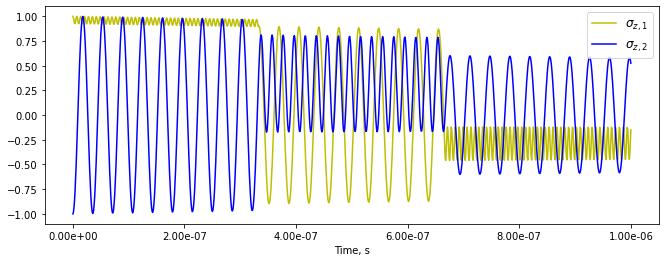

In [12]:
#plotting the results
fig, ax = plt.subplots(figsize=(11,4))    #making the figure wider

ax.plot(g_manip["time"], np.real(g_manip["sigma_z_1"]) ,"y", label = "$\sigma_{z, 1}$") 
ax.plot(g_manip["time"], np.real(g_manip["sigma_z_2"]) ,"b", label = "$\sigma_{z, 2}$") 
ax.legend(loc='upper right', fontsize='large')
plt.xlabel("Time, s")

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
     # for scientific  number format


We clearly observe residual oscillations even at large deviation $g$-factor. This happens because the detuned qubit does not return to its initial state after the resonance. The optimal way to choose $\delta g$ is implemented in `pulsegens` module for control pulse generation (see the write-up for the derivation and next section for the examples).

### Exchange interaction; scaling up to larger qubit ensembles
The exchange interaction in a chain of qubits is described by the Heisenberg Hamiltonian: $H_{ex} = \sum_i \frac{J_i}{4} \vec{\sigma}_i \cdot \vec{\sigma} _{i+1}$, where $J_i$ are exchange parameters. Knowing that a $ \mathrm{SWAP}$ operator is given by $$ \mathrm{SWAP} = \frac{1}{2}\left(\mathbb{1}_1\mathbb{1}_2 + X_1 X_2 + Y_1 Y_2 +Z_1 Z_2  \right)$$ and that $ \mathrm{SWAP}^2 = \mathbb{1}_1\mathbb{1}_2$, we could write the time evolution operator for a 2-qubit system:

$$U_J = \exp \left( -\frac{iHt}{\hbar}\right) = \exp \left(\frac{iJt}{2\hbar} \right)\exp \left(-\frac{iJt}{2\hbar} \mathrm{SWAP} \right)
= \exp \left(\frac{iJt}{2\hbar} \right) \left( \cos \frac{Jt}{2\hbar} \mathbb{1}_1\mathbb{1}_2 - i \sin\frac{Jt}{2\hbar} \mathrm{SWAP}\right)
$$ 

Neglecting the global phase factor, we conclude that the $\mathrm{SWAP}$ gate is realized when $\frac{Jt}{2\hbar}= \frac{\pi}{2}$, so we obtain $t(\mathrm{SWAP})= \frac{\pi \hbar}{J} = \frac{h}{2J} $. Consequently,  $t(\mathrm{\sqrt{SWAP}}) = \frac{h}{4J}.$

#### Two qubit exchange pulse

To start with, let us test pure exchange oscillations in the isolated 2-qubit system in the $|\uparrow \downarrow\rangle$ configuration.

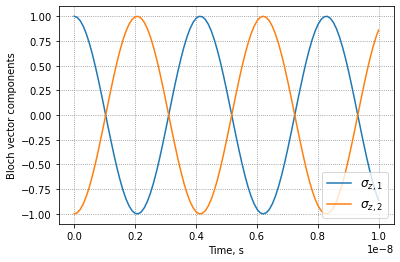

Theoretical value of SWAP time: 2.0706e-09 s


In [13]:
rho_exch = rho_up_down.copy()
exch_system = sps.SpinSys(rho_exch)  #default system parameters
exch_pulse = circ.ControlPulse("2_qubit_exchange_pulse", "effective", pulse_length=1e-8) #picoseconds
J_0 = 1.6e-25
lisj = [J_0]*500
exch_pulse.add_control_variable("J_1", lisj)
exch = exch_system.evolve(exch_pulse, track_qubits={1,2}, are_Bloch_vectors=True)

plt.plot(exch["time"],  np.real(exch["sigma_z_1"]), label = "$\sigma_{z, 1}$") 
plt.plot(exch["time"],  np.real(exch["sigma_z_2"]), label = "$\sigma_{z, 2}$")

plt.grid()
plt.rc('grid', linestyle="dotted", color='gray') #adding grid

plt.xlabel("Time, s")
plt.ylabel("Bloch vector components")
plt.legend(loc="lower right", fontsize='large')

plt.show()
print("Theoretical value of SWAP time: {:.5} s".format(consts.h/(2*J_0)))

Decide if the simulated value of SWAP time is consistent with the theoretical one.

#### Spin wave in a ferromagnet

Let us consider a 6-qubit system in the $|\downarrow \uparrow \uparrow \uparrow \uparrow \uparrow\rangle$ configuration. Let us also assume that the chain is ferromagnetic, i.e. all $J_i<0$. The ground state of such a system is achieved when all the spins are parallel. Since there is a flipped spin on the left side, we expect that it will travel to the right, i.e. induce a spin wave.
**Caution:** beware that this simulation may take a long time to complete.

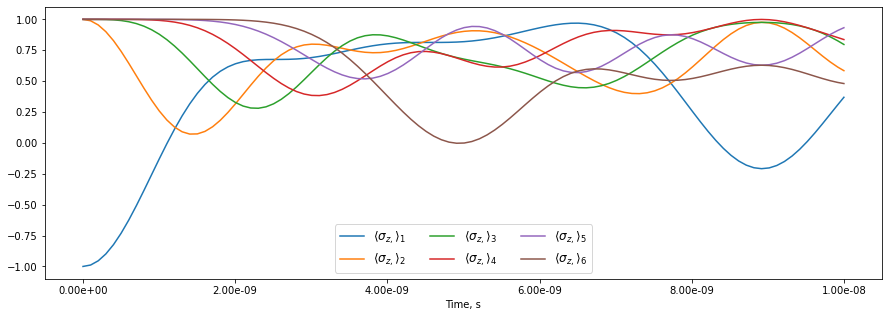

In [14]:
#defining the system
rho2_6 = np.zeros((2**5, 2**5))
rho2_6[0][0]=1
rho_six = np.kron(np.array([[0,0],[0,1]]), rho2_6)

six_el_system = sps.SpinSys(rho_six, B_0=B0 )  
sw_pulse =  circ.ControlPulse("spin_wave_pulse", "effective", pulse_length=1e-8) #picoseconds

# defining exchange between all the electrons in the chain 
for i in range(1,7):
    sw_pulse.add_control_variable("J_{}".format(i), lisj)
sw = six_el_system.evolve(sw_pulse, track_qubits={1,2,3,4,5,6}, are_Bloch_vectors=True)

fig, ax = plt.subplots(figsize=(15,5))
#fig = plt.figure(figsize=(11,4))
for i in range(1,7):
    ax.plot(sw["time"], np.real(sw["sigma_z_{}".format(i)]) , label=('⟨$\sigma_{z, }$⟩'+'$_{}$'.format(i)))

ax.legend(loc='lower center', fontsize='large',ncol=3)
plt.xlabel("Time, s")

ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
     # for scientific  number format
    

As expected, the spins are disturbed consecutively from left to right.

## 5. Simulating quantum gates

### Basic pulse generators
The `pulsegens` module contains the simple constant pulse generators for the most basic single- and two-qubit operations like single-qubit rotations, $\mathrm{SWAP}$,  $\mathrm{\sqrt{SWAP}}$. See the write-up for the background theory of how the pulses are synthesized.

### Single qubit rotations

The function `rot` from `pulsegens` module that produces single qubit rotation pulses has the following parameters:
- `qubits`: the qubit(s) to evolve under the pulse
- `axis`: "X", "Y" or "Z"
- `theta`: value in **degrees**
- `sys`: SpinSys object: simulated spin system
- `B_rf`
- (optional) `num_val` number of data points in the obtained pulse

As an example, we will evolve the $|+\rangle = \frac{1}{\sqrt{2}} \left( |0\rangle+|1\rangle \right)$ state with the $\mathrm{ROTZ}(\theta)$ gate at $\theta = \frac{\pi}{4}$. This gate is constructed in `pulsegens` as follows: 

$\mathrm{ROTZ}(\theta) = \mathrm{ROTX}(-\frac{\pi}{2}) \ \mathrm{ROTY}(\theta) \ \mathrm{ROTX}(\frac{\pi}{2})$.

As a side note, the other way to build it is by properly detuning the system from resonance with the deviation $g-$factor; this method is left as an exercise for the reader.


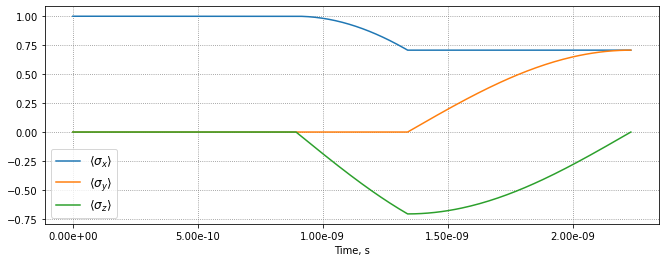

In [15]:
# Implementing ROTZ(pi/4) gate
# Starting with the superposition state $1/\sqrt{2}(|↑> + |↓>)$ (eigenstate of X operator)
rho_sup = np.array([[0.5,0.5],[0.5,0.5]])

rotz_system = sps.SpinSys(rho_sup, B_0=1, T_2=1e-4, T=4, 
                                                   f_rf=larmor_freq*0.7, time=0)

# ROTZ gate; mind that the angle is given in degrees
rotz_pi_4_pulse = pulsegens.rot_square(qubits=1, N=1, axis="Z", theta=45, B_0=rotz_system.B_0,
                                       B_rf=1e-2, f_rf=rotz_system.f_rf, num_val=100)

rotz_pi_4 = rotz_system.evolve((rotz_pi_4_pulse,),
                               track_qubits=1, are_Bloch_vectors=True)
#plotting the results
fig, ax = plt.subplots(figsize=(11,4))
#fig = plt.figure(figsize=(11,4))

ax.plot(rotz_pi_4["time"], np.real(rotz_pi_4["sigma_x_1"]) , label='⟨$\sigma_x$⟩')
ax.plot(rotz_pi_4["time"], np.real(rotz_pi_4["sigma_y_1"]) , label='⟨$\sigma_y$⟩')
ax.plot(rotz_pi_4["time"], np.real(rotz_pi_4["sigma_z_1"]) , label='⟨$\sigma_z$⟩')

ax.legend(loc='lower left', fontsize='large')
plt.xlabel("Time, s")
plt.ylabel


ax.grid()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
     # for scientific  number format


The order of Bloch vector rotations is consistent with the predictions: 
1) no turn, since the state is an eigenstate of $\sigma_x$, 

2) turn by $\frac{\pi}{4}$ in $xOz$ plane (around $\hat{y}$ axis); 

3) move towards the position between $\hat{x}$ and $\hat{y}$ axes in the $xOy$ plane.

#### $\mathrm{SWAP} $ and $ \mathrm{\sqrt{SWAP}}$ gates

These gates have already been discussed in section 4. The duration of the constant exchange pulse is as follows:

$t(\mathrm{SWAP}) = \frac{h}{2J}; \quad t(\mathrm{\sqrt{SWAP}}) = \frac{h}{4J}.$ 

The generators of these operators require the number of the left qubit in the interacting pair, magnitude of $J$, and spin system as parameters; `num_val` is optional.  

In [16]:
# testing that the |↑↓⟩ is transformed into |↓↑⟩ upon SWAP

rho_down_up =np.kron([[0,0],[0,1]], [[1,0],[0,0]])

swap_system = sps.SpinSys(rho_up_down.copy(), T_2=1e-6)
swappulse = pulsegens.swap(N=2, qubits=(1,2), J=1e-25, num_val=500)

swap = swap_system.evolve(swappulse)
print("Fideity with respect to |↓↑⟩ after SWAP: {:.8}".format(qmath.fidelity(swap_system.rho, rho_down_up) ))


Fideity with respect to |↓↑⟩ after SWAP: 0.99669245


#### CZ and CNOT gates

In [17]:
cz = np.diag([1.,1,1,-1])
cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]], dtype=complex)


We express $\mathrm{CZ}$ and  $\mathrm{CNOT}$ in terms of other gates according to Buonacorsi et al, 2019 (will be transformed to .circ files with the drawn diagrams at some point):


The gates will be checked on a randomly defined pure two-qubit system:

In [18]:
#creating a random matrix
temp = np.random.rand(4,1) + np.random.rand(4,1)*1j          # random vector 4x1
rand_state = temp / np.linalg.norm(temp)                     # properly defined state vector (random vector normalized by its norm)

rho_rand = np.kron(rand_state, rand_state.T.conj())          # random pure 2-electron density matrix

print("Random matrix:\n {}".format(np.round(rho_rand, 4)))    # np.round is used not to deal with the global precision settings
                                                             # in np.set_printoptions  

Random matrix:
 [[0.2762+0.j     0.3053+0.1125j 0.2225+0.0859j 0.1854-0.0526j]
 [0.3053-0.1125j 0.3834+0.j     0.281 +0.0043j 0.1835-0.1337j]
 [0.2225-0.0859j 0.281 -0.0043j 0.206 +0.j     0.133 -0.1001j]
 [0.1854+0.0526j 0.1835+0.1337j 0.133 +0.1001j 0.1344+0.j    ]]


Now testing $\mathrm{CZ}$ and  $\mathrm{CNOT}$ gates. __Remark__: if the value of fidelity you obtain (e.g for different parameters) is too small, it could be due to the lack of precision in the simulation. Try increasing the values of `num_val` for the pulses.  

In [19]:
#defining random system  with a small off-resonance frequency shift
params = {"B_0" : B0, "f_rf"  : larmor_freq*0.995}
rand_sys = sps.SpinSys(rho_rand, **params)

#defining CZ sequence
B_rf=1e-4
J=1e-24
delta_g = 1e-4

rz90_1 = pulsegens.rot_square(qubits=1, N=rand_sys.N_0, axis="Z", theta=90, 
                              **params, B_rf=B_rf, num_val=1300, delta_g=delta_g)
rzmin90_2 = pulsegens.rot_square(2, rand_sys.N_0, "Z", -90,  B_rf=B_rf, delta_g=delta_g, 
                                 **params, num_val=500)
rswap = pulsegens.rswap([1,2], rand_sys.N_0, J, **params, num_val=1000)
rz180_1 = pulsegens.rot_square(1, rand_sys.N_0, "Z", 180, B_rf=B_rf, **params, num_val=700)

cz_seq = [rz90_1, rzmin90_2, rswap, rz180_1 , rswap]

rand_sys.evolve(cz_seq)
ideal = cz @ rho_rand @ cz.T.conj()

print("Fideity after CZ: {:.8}".format(qmath.fidelity(rand_sys.rho, ideal)))
print("Purity after CZ: {:.8}".format(qmath.purity(rand_sys.rho)))
print("\nSimulated density matrix:\n", np.round(rand_sys.rho,4), "\n\nAfter the evolution under ideal gate" , '\n',np.round(ideal, 4))


Fideity after CZ: 0.9995124
Purity after CZ: 0.99903714

Simulated density matrix:
 [[ 0.2762+0.j      0.3054+0.1134j  0.2215+0.0863j -0.1855+0.0515j]
 [ 0.3054-0.1134j  0.3844+0.j      0.2804+0.0048j -0.1842+0.1331j]
 [ 0.2215-0.0863j  0.2804-0.0048j  0.205 +0.j     -0.1327+0.0995j]
 [-0.1855-0.0515j -0.1842-0.1331j -0.1327-0.0995j  0.1345+0.j    ]] 

After the evolution under ideal gate 
 [[ 0.2762+0.j      0.3053+0.1125j  0.2225+0.0859j -0.1854+0.0526j]
 [ 0.3053-0.1125j  0.3834+0.j      0.281 +0.0043j -0.1835+0.1337j]
 [ 0.2225-0.0859j  0.281 -0.0043j  0.206 +0.j     -0.133 +0.1001j]
 [-0.1854-0.0526j -0.1835-0.1337j -0.133 -0.1001j  0.1344+0.j    ]]


In [20]:
#testing a CNOT pulse right after CZ; 
#multiple runs of this cell are equivalent to multiple CNOTs after CZ

new_rho_rand = rand_sys.rho

rymin90_2 =  pulsegens.rot_square(2, rand_sys.N_0, "Y", -90,  B_rf=B_rf, delta_g=delta_g, 
                                 **params, num_val=1400)
ry90_2 =  pulsegens.rot_square(2, rand_sys.N_0, "Y", 90, B_rf=B_rf, delta_g=delta_g, **params)

cnot_seq = [rymin90_2, cz_seq, ry90_2]

rand_sys.evolve(cnot_seq)
ideal = cnot @ new_rho_rand @ cnot.T.conj()

print("Fideity after CNOT: {:.8}".format(qmath.fidelity(rand_sys.rho, ideal)))
print("Purity after CNOT: {:.8}".format(qmath.purity(rand_sys.rho)))
print("\nSimulated density matrix:\n", np.round(rand_sys.rho,4), 
          "\n\nAfter the evolution under ideal gate:" , '\n',np.round(ideal, 4))


Fideity after CNOT: 0.99970362
Purity after CNOT: 0.99734761

Simulated density matrix:
 [[ 0.2764+0.j      0.3053+0.1138j -0.1855+0.0493j  0.2204+0.0883j]
 [ 0.3053-0.1138j  0.3843+0.j     -0.1848+0.131j   0.2799+0.007j ]
 [-0.1855-0.0493j -0.1848-0.131j   0.1343+0.j     -0.1327-0.0993j]
 [ 0.2204-0.0883j  0.2799-0.007j  -0.1327+0.0993j  0.205 +0.j    ]] 

After the evolution under ideal gate: 
 [[ 0.2762+0.j      0.3054+0.1134j -0.1855+0.0515j  0.2215+0.0863j]
 [ 0.3054-0.1134j  0.3844+0.j     -0.1842+0.1331j  0.2804+0.0048j]
 [-0.1855-0.0515j -0.1842-0.1331j  0.1345+0.j     -0.1327-0.0995j]
 [ 0.2215-0.0863j  0.2804-0.0048j -0.1327+0.0995j  0.205 +0.j    ]]
